# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

In [1]:
# Your code here

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
import warnings

warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv('../data/boston_data.csv')
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,21.7
1,0.10328,25.0,5.13,0.0,0.453,5.927,47.2,6.9320,8.0,284.0,19.7,396.90,9.22,19.6
2,0.34940,0.0,9.90,0.0,0.544,5.972,76.7,3.1025,4.0,304.0,18.4,396.24,9.97,20.3
3,2.73397,0.0,19.58,0.0,0.871,5.597,94.9,1.5257,5.0,403.0,14.7,351.85,21.45,15.4
4,0.04337,21.0,5.64,0.0,0.439,6.115,63.0,6.8147,4.0,243.0,16.8,393.97,9.43,20.5


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 14 columns):
crim       404 non-null float64
zn         404 non-null float64
indus      404 non-null float64
chas       404 non-null float64
nox        404 non-null float64
rm         404 non-null float64
age        404 non-null float64
dis        404 non-null float64
rad        404 non-null float64
tax        404 non-null float64
ptratio    404 non-null float64
black      404 non-null float64
lstat      404 non-null float64
medv       404 non-null float64
dtypes: float64(14)
memory usage: 44.3 KB


In [4]:
data.isnull().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

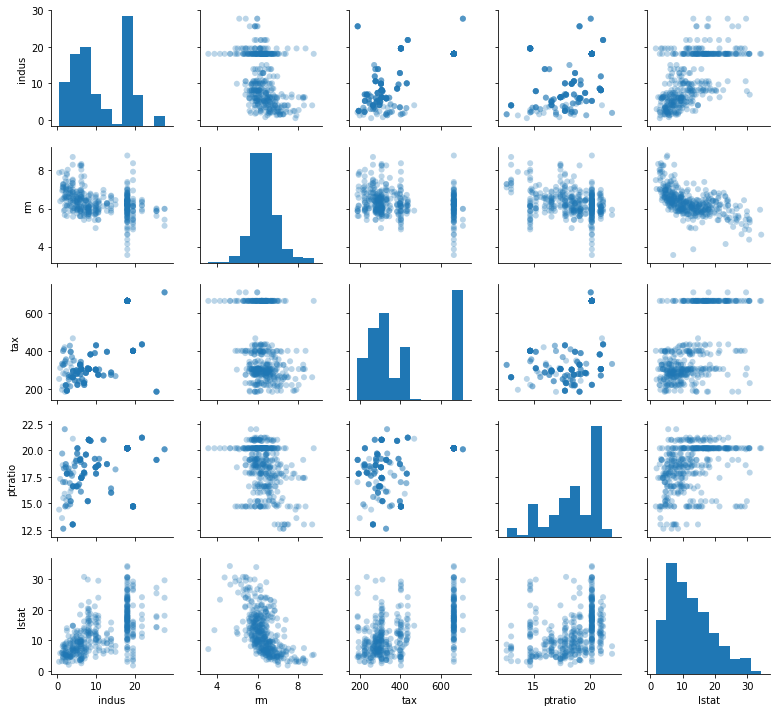

In [5]:
columns = ['indus', 'rm', 'tax', 'ptratio', 'lstat']
sns.pairplot(data[columns], plot_kws=dict(alpha=.3, edgecolor='none'), height=2, aspect=1.1)

Text(0.5, 1, 'Correlation between variables of the Dataset')

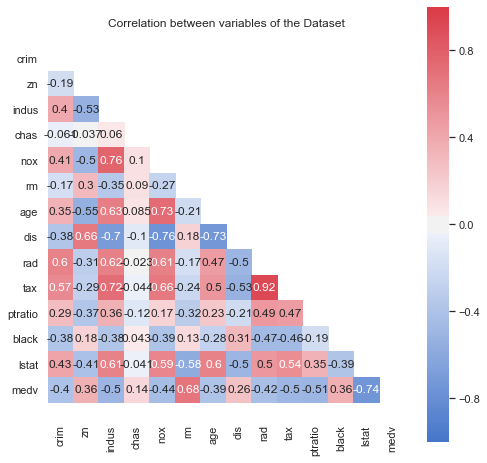

In [6]:
# Your plots here

# Correlation Matrix Heatmap Visualization
sns.set(style="white")
# Generate a mask for the upper triangle
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(8,8))
# Create a custom color palette
cmap = sns.diverging_palette(255, 10, as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors
# Red=10, Green=128, Blue=255
# Plot the heatmap
sns.heatmap(data.corr(), mask=mask, annot=True, square=True, cmap=cmap , vmin=-1, vmax=1, ax=ax)  # annot display corr label
# Prevent Heatmap Cut-Off Issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)
ax.set_title('Correlation between variables of the Dataset')

Text(0.5, 1, 'Predictive Power of the Variables of the Dataframe')

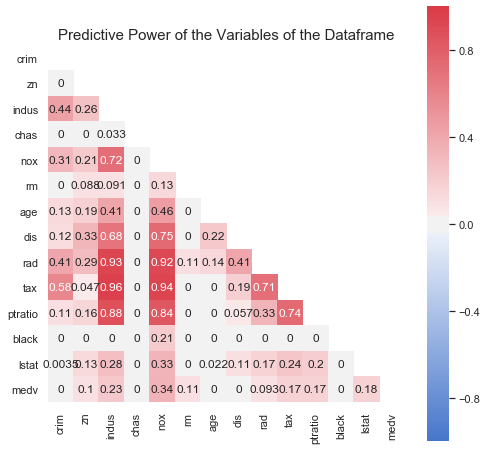

In [7]:
## Predictive Power

ppsm = pps.matrix(data)
fig, ax = plt.subplots(figsize=(8,8))
cmap = sns.diverging_palette(255, 10, as_cmap=True)
sns.heatmap(ppsm, mask=mask,annot=True, square=True, cmap=cmap , vmin=-1, vmax=1)
ax.set_title('Predictive Power of the Variables of the Dataframe', size=15)

### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

In [8]:
# The variables most correlated with mdev are 'indus', 'rm', 'tax', 'ptratio' and 'lstat'

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

In [9]:
# Your response here

# See heatmap above

### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [10]:
# Your code here

data.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.00000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.730912,10.509901,11.189901,0.069307,0.556710,6.30145,68.601733,3.799666,9.836634,411.688119,18.444554,355.068243,12.598936,22.312376
std,8.943922,22.053733,6.814909,0.254290,0.117321,0.67583,28.066143,2.109916,8.834741,171.073553,2.150295,94.489572,6.925173,8.837019
min,0.006320,0.000000,0.460000,0.000000,0.392000,3.56100,2.900000,1.169100,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082382,0.000000,5.190000,0.000000,0.453000,5.90275,45.800000,2.087875,4.000000,281.000000,17.375000,374.710000,7.135000,17.100000
50%,0.253715,0.000000,9.795000,0.000000,0.538000,6.23050,76.600000,3.207450,5.000000,330.000000,19.000000,391.065000,11.265000,21.400000
75%,4.053158,12.500000,18.100000,0.000000,0.631000,6.62925,94.150000,5.222125,24.000000,666.000000,20.200000,396.007500,16.910000,25.000000
max,88.976200,95.000000,27.740000,1.000000,0.871000,8.78000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,34.370000,50.000000


In [11]:
### Remove rad due high correlation with tax

X = data.drop(['rad', 'medv'], axis=1)
y = data['medv']

----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [12]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    # Your code here:
    return r2_score(y_true, y_predict)

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [13]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25, shuffle=True)


----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [36]:
# Five separate RFR here with the given max depths
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {'max_depth': [2, 4, 6, 8, 10]}
CV_rfc = GridSearchCV(RandomForestRegressor(n_estimators=100, random_state=42), param_grid, cv=10)
CV_rfc.fit(X_train, y_train)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [2, 4, 6, 8, 10]},
   

Now, plot the score for each tree on the training set and on the testing set.

In [33]:
train_scores = pd.DataFrame(CV_rfc.cv_results_)
train_scores[['params', 'mean_test_score', 'std_test_score']]

,params,mean_test_score,std_test_score
0,{'max_depth': 2},0.706831,0.081972
1,{'max_depth': 4},0.801356,0.094376
2,{'max_depth': 6},0.819810,0.099104
3,{'max_depth': 8},0.820085,0.102526
4,{'max_depth': 10},0.821622,0.099337


In [34]:
CV_rfc.fit(X_test, y_test)
test_scores = pd.DataFrame(CV_rfc.cv_results_)
test_scores[['params', 'mean_test_score', 'std_test_score']]

,params,mean_test_score,std_test_score
0,{'max_depth': 2},0.503695,0.344290
1,{'max_depth': 4},0.577206,0.326638
2,{'max_depth': 6},0.603719,0.317798
3,{'max_depth': 8},0.601934,0.310891
4,{'max_depth': 10},0.600063,0.314162


What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [ ]:
# At depth 8-10 there is not a clear improvement over the model, which could indicate an overfitting.

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10?

In [35]:
# Your response here

# At maximum depth of 2, it seems to indicate a problem with underfitting, indicating that the models suffers from a high bias. 
#It can be seen due a bad performance in the training test, but a much better performance in the test set.
# At maximum depths 8 to 10, it seems to indicate a problem with overfitting, the model suffer from high variance, 
# adding noise from the training set to the model.

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [37]:
# The best optimal depth should be between 4-8. Let's make some calculations!!

param_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8]}
CV_rfc = GridSearchCV(RandomForestRegressor(n_estimators=100, random_state=42), param_grid, cv=10)
CV_rfc.fit(X_train, y_train)
train_scores = pd.DataFrame(CV_rfc.cv_results_)
train_scores[['params', 'mean_test_score', 'std_test_score']]

,params,mean_test_score,std_test_score
0,{'max_depth': 2},0.706831,0.081972
1,{'max_depth': 3},0.770031,0.080667
2,{'max_depth': 4},0.801356,0.094376
3,{'max_depth': 5},0.811131,0.099699
4,{'max_depth': 6},0.819810,0.099104
5,{'max_depth': 7},0.816870,0.097435
6,{'max_depth': 8},0.820085,0.102526


In [38]:
CV_rfc.fit(X_test, y_test)
test_scores = pd.DataFrame(CV_rfc.cv_results_)
test_scores[['params', 'mean_test_score', 'std_test_score']]

,params,mean_test_score,std_test_score
0,{'max_depth': 2},0.503695,0.344290
1,{'max_depth': 3},0.560987,0.330140
2,{'max_depth': 4},0.577206,0.326638
3,{'max_depth': 5},0.594337,0.323442
4,{'max_depth': 6},0.603719,0.317798
5,{'max_depth': 7},0.602176,0.310701
6,{'max_depth': 8},0.601934,0.310891


In [ ]:
## Comparing the params at 6 the model does not improve. 
## However, the test has a lot of variance which indicates bad performance in prediction (could predict very well or very bad).

### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [ ]:
# Your response here

# 1) The data collected from 1978 could not be the best data to descrive or extrapolate to current data days, due some changes during this time.
# 2) Although the features seems to have a good correlation with the target, it lacks some predictive power.
# 3) The model has very high variance in order to make prediction, which indicates that it is not robust enough.
# 4) The data from a rural city probably not be applicable to a big city like Boston.